## The Curse of Dimensionality

From the book A Geron. Let's dive in what he is trying to explain

Many Machine Learning problems involve thousands or even millions of features for each training
instance. Not only does this make training extremely slow, it can also make it much harder to find a good
solution, as we will see. This problem is often referred to as the curse of dimensionality.

Yes, it speed up the training, but it also helps in data visualization. Ploting data in 2D instead.

### Some tips
Always start training with no dimension reduction. It may damage your training. since you are taking some might be relevant information out.

All training instances actually lie within (or close to) a much lower-dimensional subspace of the
high-dimensional space. To see this, we can **project** data points on two dim axes and see how well they are represented.

### Three type of dimension reduction (most popular)
PCA, Kernel PCA, and LLE

#### PCA
Principal Component Analysis (PCA) is by far the most popular dimensionality reduction algorithm.
First it identifies the hyperplane that lies closest to the data, and then it projects the data onto it.
In meaning that the variance of a given feature reprensent the information that it contient. The PCA method tends to minimize the loss of the variance by projecting original feature on their most closest hyperplane.

there is a standard matrix
factorization technique called Singular Value Decomposition (SVD) that can decompose the training set
matrix X into the dot product of three matrices U · Σ · VT, where VT contains all the principal components
that we are looking for.

In [14]:
import numpy as np

# let's create X
X=np.random.randn(10,10)
X_centered = X - X.mean(axis=0)                # let's center variables first
U, s, V = np.linalg.svd(X_centered)            # Now we can use SVD to construct the correlation matrix
c1 = V.T[:, 0] 
c2 = V.T[:, 1]
np.corrcoef(c1,c2) # we can show that c1 and c2 are not correlated

array([[ 1.        , -0.04950348],
       [-0.04950348,  1.        ]])

PCA assumes that the dataset is centered around the origin. As we will see, **Scikit-Learn**’s PCA classes take care of centering the data for you. However, if you implement PCA yourself (as in the preceding example), or if you use other libraries, don’t forget to **center** the data first.

Here let's project the training set onto the plane defined by the first two principal components

In [31]:
W2 = V.T[:, :2]
X2D = X_centered.dot(W2) 

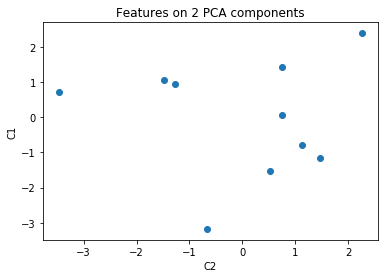

In [32]:
import matplotlib.pyplot as plt
plt.scatter(X2D[:,0], X2D[:,1])
plt.title('Features on 2 PCA components')
plt.ylabel('C1')
plt.xlabel('C2')
plt.savefig('PCA.png')
plt.show()

In [46]:
X2D[:,0]

array([-1.46310855,  0.66029397,  1.27451354,  3.47272974, -0.75634412,
       -1.13372295, -0.7501887 , -0.51423669,  1.47435236, -2.2642886 ])

#### Using Scikit-Learn
Scikit-Learn’s PCA class implements PCA using **SVD** decomposition just like we did before. The
following code applies PCA to reduce the dimensionality of the dataset down to two dimensions (note
that it **automatically takes care of centering the data**)

In [47]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 3) # choose the number of component to keep
#X2D0 = pca.fit_transform(X)
# pca.components_.T[:, 0] # not working 
# print(pca.explained_variance_ratio_) # the explained variance ratios of the first two components of the 3D dataset

The following code computes PCA without reducing dimensionality, then computes the minimum number
of dimensions required to preserve 95% of the training set’s variance:

In [48]:
pca = PCA()
pca.fit(X)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

You could then set n_components=d and run PCA again.

In [51]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X)